# PINN Study Note

## Basic Theory

### Maziar

Basic structure

$$
\left.\begin{aligned}
y_i=f(x_i)+\epsilon_i,\ \epsilon\sim\mathcal{N}(0, \sigma^2),\ i=1, ..., N\\
\mathbf{y} = f(\mathbf{x})+\epsilon,\ \epsilon\sim \mathcal{N}(\mathbf{0}, \delta^2\mathbf{I})
\end{aligned}
\right\}
\text{Data}
$$

$$
\left.\begin{aligned}
f(x)=W^L h^L+b^L\\
h^L=\tanh(W^{L-1}h^{L-1}+b^{L-1})\\
\vdots\\
h^1=\tanh(W^0x+b^0)
\end{aligned}
\right\}
\text{Prior}
$$

$$
\left.
\begin{aligned}
\mathbf{y}\sim\mathcal{N}(f(\mathbf{x}),\ \delta^2\mathbf{I})\\
\min\limits_{W, b}(\mathbf{y}-f(\mathbf{x}))'(\mathbf{y}-f(\mathbf{x}))\\
\min\limits_{W, b}\sum^N_{i=1}|y_i-f(x_i)|^2
\end{aligned}
\right\}
\text{Training}
$$

$$
\left.
\begin{aligned}
\\
f(x^*)
\\
\\
\end{aligned}
\right\}
\text{Prediction}
$$

I can barely understand most of them.

### Ilias

What are neural networks?

Affine transformations followed by non-linearities parameters: $\theta$.
Function: $y=\mathcal{N}(x;\theta)$

How do we train neural networks?

Focusing on regression. You have some data consisting of **inputs** $x_{1:n} = (x_1, ..., x_n)$ and **outputs** $y_{1:n}=(y_1, ..., y_n)$, you would want to find a neural net, 
that could **minimize** a **loss functions**:

$$
L(\theta)=\frac{1}{n}\sum^n_{i=1}[y_i - \mathcal{N}(x_i;\theta)]^2.
$$

We typically use a form of **stochastic gradient descent**

$$
\theta_{t+1} = \theta_t - a_t\frac{1}{m}\sum^m_{j=1}\nabla_\theta
\left[y_{i_i}-N(x_{i_i}; \theta_t)
\right]^2,
$$
where 
1. $y_{i_i}$ and $x_{i_i}$ are the randomly sampled batch of inputs/outputs (a subset of the domain)
2. $\nabla$ Automatic differentiation for getting gradients (PyTorch, TensorFlow)
3. $a_t$ Learning rate which has to satisfy certain constraints.

## Example

### Solving an ODE

From ODE to a loss function

* Consider the initial value problem:
$$
\begin{aligned}
\frac{\mathrm{d}\Psi}{\mathrm{d}x} &= f(x,\Psi)\\
\Psi(0) &= A
\end{aligned}
$$

* Automatically satisfy the initial condition by parameterizing the solution as:
$$
\hat{\Psi}(x; \theta)=A+x\mathcal{N}(x;\theta)
$$

* The idea is to find $\theta$ by minimizing the integrated squared residual of the ODE:

$$
L(\theta) = \int_0^1
\left[
    \frac{\mathrm{d}\hat{\Psi}(x;\theta)}{\mathrm{d}x}-f(x, \hat{\Psi}{(x;\theta)})
\right]^2\mathrm{d}x
$$ 

* The following algorithm converges (Robbins-Monro, 1951)

$$
\theta_{t+1} = \theta_t - \frac{a_t}{n}\sum^n_{i=1}\nabla_\theta\left[
    \frac{\mathrm{d}\hat{\Phi}(x_i;\theta_t)}{\mathrm{d}x}-f(x_i,\hat{\Psi}(x_i;\theta_t))
\right]^2
$$

### Solving an elliptic PDE

From PDEs to a loss functino - Integrated squared approach

$$
-\nabla\cdot[a(x)\nabla u(x)] + c(x) u(x) = f(x)
$$

Than we get loss function as:

$$
L(\theta) = \int \left\{
\nabla\cdot [a(x)\nabla \hat{u}(x; \theta)]+c(x)\hat{u}(x;\theta) + f(x)
\right\}^2\mathrm{d}x
$$

From PDEs to a loss function - Energy approach

$$
-\nabla\cdot [a(x)\nabla u(x)] + c(x)u(x)=f(x)
$$

By dirichlet principle:

$$
\begin{aligned}
L(\theta) &= \int
\left\{
\frac{1}{2}a(x)\nabla\hat{u}(x;\theta)+c(x)\hat{u}^2(x;\theta)-f(x)\hat{u}(x;\theta)
\right\}\mathrm{d}x\\
&-\int_{\Gamma_N} g_N \hat{u}(x;\theta)\mathrm{d}\Gamma_N
\end{aligned}
$$

$\Gamma$ is the boundary

Why is this useful?

Solving PDEs for all possible parameterizations

$$
-\nabla\cdot[a(x;\xi)\nabla u(x;\xi)]+c(x)u(x;\xi)=f(x)
$$

Boundary conditions:

$$
\begin{aligned}
&u=0, &\forall x_1 = 1,\\
&u=1, &\forall x_1 = 0,\\
&\frac{\partial u}{\partial n}=0, &\forall x_2=1.
\end{aligned}
$$

By using Dirichlet princile, we just treate $\xi$ like we treate normal spatial variable.

$$
\begin{aligned}
L(\theta) &= 
\mathbb{E}_\xi\left[
\int
\left\{
\frac{1}{2}a(x)\nabla\hat{u}(x;\theta)+c(x)\hat{u}^2(x;\theta)-f(x)\hat{u}(x;\theta)
\right\}\mathrm{d}x\right.\\
&\left.-\int_{\Gamma_N} g_N \hat{u}(x;\theta)\mathrm{d}\Gamma_N\right]
\end{aligned}
$$

What are the applications of this?

* High-dimeninonal uncertainty propagation through PDEs.
* Solving free boundary and Stefan problems. (Wang, Perdikaris, 2021).
* PDE-constrained optimization (Hennigh et al., 2020).
* Inverse/model calibration problems (Rais, 2019).
* Data assimilation/filtering (no one yet).
* ...

What is the catch?

* Not as easy as it looks in practive ...
* Vanishing gradients ...
* Spectral bias of deep nets ... (If learned smooth things, it will take forever to learn high frequency), we can using Fourier feature of the network to solve the problem.

## My playground

In [104]:
import torch
import torch.nn as nn
from time import perf_counter
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import requests
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Solving ODEs

### Solving ODEs' IVP

Considering the ODEs:

$$
2\Psi'''+\Psi \Psi''=0,
$$

with $x\in[0, 1]$ and initial condision (IC):

$$
\Psi_0(0) = 0,\\
\Psi_1(0) = 1,\\
\Psi_2(0) = -1,
$$

where $\Psi_0=\Psi, \Psi_1=\Psi', \Psi_2=\Psi''$.


It can be rewrite as
$$
\begin{aligned}
    &\frac{\mathrm{d}\Psi_0}{\mathrm{d}x} = f_1(x, \Psi_0, \Psi_1, \Psi_2)=\Psi_1\\
    &\frac{\mathrm{d}\Psi_1}{\mathrm{d}x} = f_2(x, \Psi_0, \Psi_1, \Psi_2)=\Psi_2\\
    &\frac{\mathrm{d}\Psi_2}{\mathrm{d}x} = f_3(x, \Psi_0, \Psi_1, \Psi_2)=-\frac{1}{2}\Psi_0\Psi_2
\end{aligned}
$$

We write the trial solution by:
$$
\mathbf{\hat{\Psi}}(x; \theta) = (0, 1, -1)^T + x \mathcal{N}(x; \theta),
$$
where $\mathcal{N}(x; \theta)$ is a neural network (NN).
The solution is $\mathbf{\hat{\Psi}}(x;\theta)$ automatically satisfied the initial conditions.
The loss function we would like to minimize to train the NN is:
$$
L(\theta) = \int_0^1 \left|\frac{\mathrm{d}\mathbf{\hat{\Psi}}(x;\theta)}{dx} - f(x,\mathbf{\hat{\Psi}}(x;\theta))\right|_2\mathrm{d}x
$$

Let's just use `scipy` to solve the problem.

In [105]:
from scipy.integrate import solve_ivp

def odes(t, y):
    return np.array( 
        [y[1], y[2], -0.5*y[0]*y[2]]
    )

t_span = np.array([0, 1])
y0 = np.array([0, 1, -1])
# Dense output must be set as true, otherwise we cannot plot more points.
sol = solve_ivp(odes, t_span, y0, dense_output=True)

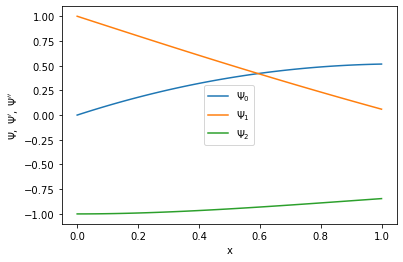

In [106]:
t_scipy = np.linspace(0, 1, 100)
y_scipy = sol.sol(t_scipy)
fig, ax = plt.subplots()
for i in range(3):
    ax.plot(t_scipy, y_scipy[i], label="$\Psi_{}$".format(i))
_ = ax.legend()
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("$\Psi,\ \Psi',\ \Psi''$")

Let's try to use Neural Network to solve this ivp.

In [107]:
# Define out Neural Network with two layers, 3->150->3

layer_number = 50
N = nn.Sequential(
    nn.Linear(1, layer_number), nn.Sigmoid(), 
    nn.Linear(layer_number, layer_number, bias=True), nn.Sigmoid(), 
    nn.Linear(layer_number, 3, bias=False))

# Set the Initial condition
A = torch.tensor(np.array([0, 1, -1]))

# From Neural Network to the result we need
Psi_t = lambda x: A + x * N(x)

def f(x, Psi):
    foo = torch.ones_like(Psi)
    foo[:, 0] = Psi[:, 1]
    foo[:, 1] = Psi[:, 2]
    foo[:, 2] = -0.5*Psi[:, 0]*Psi[:, 2]
    return foo

# function used for gradient
def grad(outputs, inputs):
    """
    This is useful for taking derivatives
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

# The loss function
def loss(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    # The gradient of the Psi

    Psi_tx = torch.ones_like(outputs)
    for i in range(3):
        Psi_tx[:, i] = grad(outputs[:, i], x)[:, 0]
    return torch.mean((Psi_tx - f(x, outputs)) ** 2)


In [108]:
# Optimize (same algorithm as in Lagaris)
optimizer = torch.optim.LBFGS(N.parameters())

# The collocation points used by Lagaris
x = torch.Tensor(np.linspace(0, 1, 100)[:, None])

# Run the optimizer
def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    return l
    
for i in range(10):
    optimizer.step(closure)

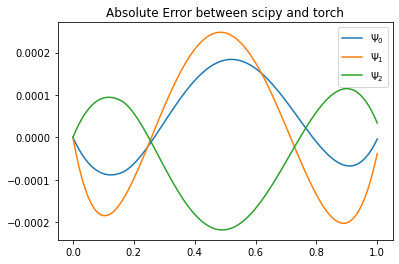

In [109]:
# Let's compare the result to the true solution
t_test = t_scipy[:, None]
with torch.no_grad():
    y_torch = Psi_t(torch.Tensor(t_test)).numpy()
fig, ax = plt.subplots()

for i in range(0,3):
    ax.plot(t_test, (y_torch[:, i]-y_scipy[i]), label="$\Psi_{}$".format(i))
_ = ax.legend()
_ = ax.set_title("Absolute Error between scipy and torch")

### Solving ODEs' BVP

Considering the ODEs:

$$
2\Psi'''+\Psi \Psi''=0,
$$

with $x\in[0, 1]$ and initial condision (IC):

$$
\Psi_0(0) = 0,\\
\Psi_1(0) = 0,\\
\Psi_1(6) = 1,
$$

where $\Psi_0=\Psi, \Psi_1=\Psi', \Psi_2=\Psi''$.


It can be rewrite as
$$
\begin{aligned}
    &\frac{\mathrm{d}\Psi_0}{\mathrm{d}x} = f_1(x, \Psi_0, \Psi_1, \Psi_2)=\Psi_1\\
    &\frac{\mathrm{d}\Psi_1}{\mathrm{d}x} = f_2(x, \Psi_0, \Psi_1, \Psi_2)=\Psi_2\\
    &\frac{\mathrm{d}\Psi_2}{\mathrm{d}x} = f_3(x, \Psi_0, \Psi_1, \Psi_2)=-\frac{1}{2}\Psi_0\Psi_2
\end{aligned}
$$

We write the trial solution by:
$$
\mathbf{\hat{\Psi}}(x; \theta) = \mathcal{N}(x; \theta),
$$
where $N(x; \theta)$ is a neural network (NN).
The solution is $\mathbf{\hat{\Psi}}(x;\theta)$ automatically satisfied the initial conditions.
The loss function we would like to minimize to train the NN is:
$$
L(\theta) = \int_0^6 \left|\frac{\mathrm{d}\mathbf{\hat{\Psi}}(x;\theta)}{dx} - f(x,\mathbf{\hat{\Psi}}(x;\theta))\right|_2\mathrm{d}x + |\Psi_0(0;\theta)| + |\Psi_1(0;\theta)| + |\Psi_1(6;\theta) - 1|
$$

Again, just use `scipy` to solve the problem.

In [311]:
def equs(x, y):
    return np.array(
        [ 
            y[1],
            y[2],
            -0.5*y[0]*y[2]
        ]
    )

def bc(ya, yb):
    return np.array(
        [ 
            ya[0],
            ya[1],
            yb[1]-1.,
        ]
    )

node_number = 101
x_bvp_scipy = np.linspace(0., 6., node_number)
y_bvp_scipy = np.array( 
    [ 
        np.linspace(0, 5, node_number),
        np.linspace(0, 1, node_number),
        np.linspace(0.3, 0.0, node_number)
    ]
)

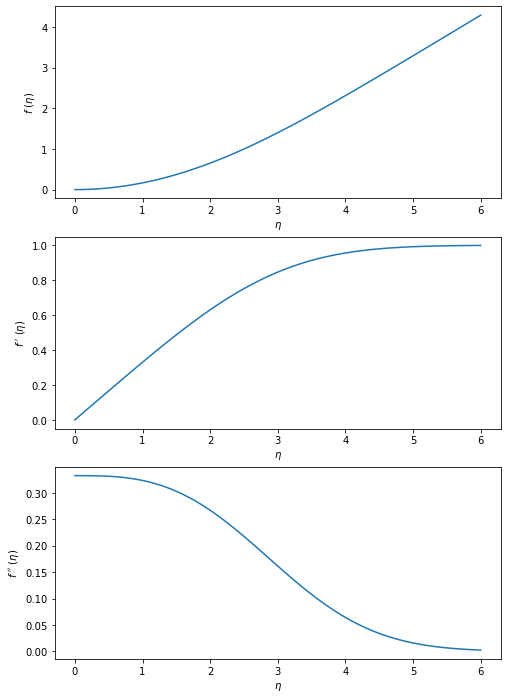

In [312]:
from scipy.integrate import solve_bvp

res = solve_bvp(equs, bc, x_bvp_scipy, y_bvp_scipy)

x_plot = np.linspace(0., 6., node_number)
y0 = res.sol(x_plot)[0]
y1 = res.sol(x_plot)[1]
y2 = res.sol(x_plot)[2]

from matplotlib import pyplot as plt
fig = plt.figure(figsize=[8, 12])

_ = ax = fig.add_subplot(311)
_ = ax.plot(x_plot, y0)
_ = ax.set_xlabel(r"$\eta$")
_ = ax.set_ylabel(r"$f\ (\eta)$")

_ = ax = fig.add_subplot(312)
_ = ax.plot(x_plot, y1)
_ = ax.set_xlabel(r"$\eta$")
_ = ax.set_ylabel(r"$f^{\ \prime}\ (\eta)$")

_ = ax = fig.add_subplot(313)
_ = ax.plot(x_plot, y2)
_ = ax.set_xlabel(r"$\eta$")
_ = ax.set_ylabel(r"$f^{\ \prime\prime}\ (\eta)$")


Now, let's try to use Neural Network to solve the problem.

In [313]:
# Define out Neural Network with two layers, 1->50->3

layer_number = 50
N = nn.Sequential(
    nn.Linear(1, layer_number), nn.Sigmoid(), 
    nn.Linear(layer_number, layer_number, bias=True), nn.Sigmoid(), 
    nn.Linear(layer_number, layer_number, bias=True), nn.Sigmoid(), 
    nn.Linear(layer_number, 3, bias=False))

Psi_t = lambda x: N(x)

def f(x, Psi):
    foo = torch.ones_like(Psi)
    foo[:, 0] = Psi[:, 1]
    foo[:, 1] = Psi[:, 2]
    foo[:, 2] = -0.5*Psi[:, 0]*Psi[:, 2]
    return foo

# function used for gradient
def grad(outputs, inputs):
    """
    This is useful for taking derivatives
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

def greater_than0(t0):
    return torch.sum(torch.abs(torch.abs(t0)-t0))

def less_than0(t0):
    return torch.sum(torch.abs(torch.abs(t0)+t0))

# The loss function
def loss(x):
    res = torch.tensor(0.0)
    x.requires_grad = True
    outputs = Psi_t(x)
    # The gradient of the Psi
    Psi_tx = torch.ones_like(outputs)
    for i in range(3):
        Psi_tx[:, i] = grad(outputs[:, i], x)[:, 0]
    res1 = torch.mean((Psi_tx - f(x, outputs)) ** 2)*6 # Governing equation
    res2 = torch.abs(outputs[0, 0]) + torch.abs(outputs[0, 1]) # Left hand side B.C.
    res3 = torch.abs(outputs[-1, 1] - 1.0) # Right hand side B.C.
    # res4 = less_than0(Psi_tx[:, 2]) # mono of f''
    return res1+res2+res3

In [314]:
# Let's see now if a stochastic optimizer makes a difference
adam = torch.optim.Adam(N.parameters(), lr=0.01)

# The batch size you want to use (how many points to use per iteration)
n_batch = 23

# The maximum number of iterations to do
max_it = 100000

for i in range(max_it):
    # Randomly pick n_batch random x's:
    x = 6 * torch.rand(n_batch, 1)
    x[0] = 0.
    x[-1] = 6.
    # Zero-out the gradient buffers
    adam.zero_grad()
    # Evaluate the loss
    l = loss(x)
    # Calculate the gradients
    l.backward()
    # Update the network
    adam.step()
    # Print the iteration number
    if i % 100 == 99:
        print(i+1, l)

100 tensor(0.3121, grad_fn=<AddBackward0>)
200 tensor(0.0514, grad_fn=<AddBackward0>)
300 tensor(0.1276, grad_fn=<AddBackward0>)
400 tensor(0.0244, grad_fn=<AddBackward0>)
500 tensor(0.0874, grad_fn=<AddBackward0>)
600 tensor(0.0384, grad_fn=<AddBackward0>)
700 tensor(0.0210, grad_fn=<AddBackward0>)
800 tensor(0.0232, grad_fn=<AddBackward0>)
900 tensor(0.0624, grad_fn=<AddBackward0>)
1000 tensor(0.0430, grad_fn=<AddBackward0>)
1100 tensor(0.0482, grad_fn=<AddBackward0>)
1200 tensor(0.0559, grad_fn=<AddBackward0>)
1300 tensor(0.0181, grad_fn=<AddBackward0>)
1400 tensor(0.0380, grad_fn=<AddBackward0>)
1500 tensor(0.0304, grad_fn=<AddBackward0>)
1600 tensor(0.0122, grad_fn=<AddBackward0>)
1700 tensor(0.0104, grad_fn=<AddBackward0>)
1800 tensor(0.0110, grad_fn=<AddBackward0>)
1900 tensor(0.0100, grad_fn=<AddBackward0>)
2000 tensor(0.0168, grad_fn=<AddBackward0>)
2100 tensor(0.0279, grad_fn=<AddBackward0>)
2200 tensor(0.0253, grad_fn=<AddBackward0>)
2300 tensor(0.0273, grad_fn=<AddBackward0

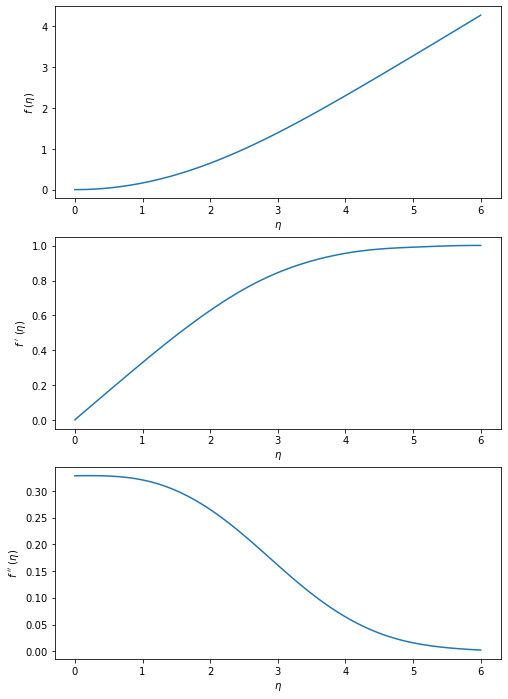

In [315]:
x_plot = np.linspace(0., 6., 101)
xx = x_plot[:, None]
with torch.no_grad():
    y_torch = Psi_t(torch.Tensor(xx)).numpy()

fig = plt.figure(figsize=[8, 12])

_ = ax = fig.add_subplot(311)
_ = ax.plot(x_plot, y_torch[:, 0])
_ = ax.set_xlabel(r"$\eta$")
_ = ax.set_ylabel(r"$f\ (\eta)$")

_ = ax = fig.add_subplot(312)
_ = ax.plot(x_plot, y_torch[:, 1])
_ = ax.set_xlabel(r"$\eta$")
_ = ax.set_ylabel(r"$f^{\ \prime}\ (\eta)$")

_ = ax = fig.add_subplot(313)
_ = ax.plot(x_plot, y_torch[:, 2])
_ = ax.set_xlabel(r"$\eta$")
_ = ax.set_ylabel(r"$f^{\ \prime\prime}\ (\eta)$")


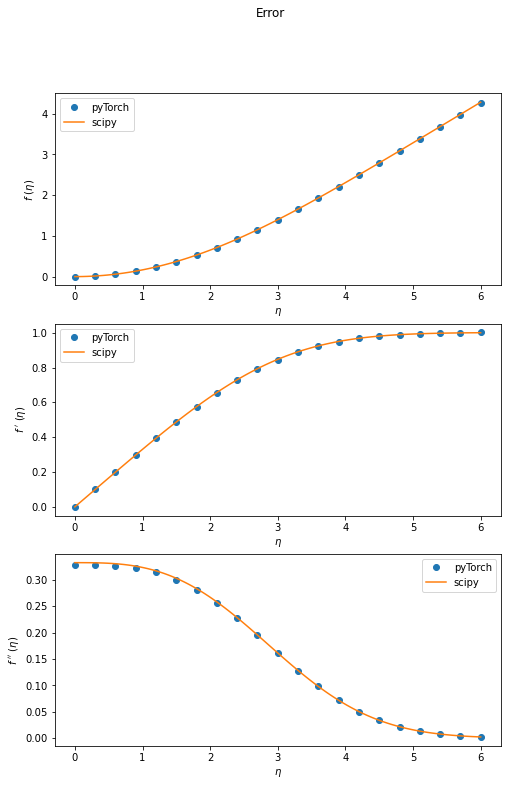

In [316]:
xx = np.linspace(0., 6., 21)[:, None]
with torch.no_grad():
    y_torch = Psi_t(torch.Tensor(xx)).numpy()

fig = plt.figure(figsize=[8, 12])

fig.suptitle("Error")

y_abs_mean = np.array( 
    [np.mean(np.abs(y0)), np.mean(np.abs(y1)), np.mean(np.abs(y2))]
)

_ = ax = fig.add_subplot(311)
_ = ax.plot(xx, y_torch[:, 0], 'o', label = "pyTorch")
_ = ax.plot(x_plot, y0, label = "scipy")
_ = ax.set_xlabel(r"$\eta$")
_ = ax.set_ylabel(r"$f\ (\eta)$")
_ = ax.legend()

_ = ax = fig.add_subplot(312)
_ = ax.plot(xx, y_torch[:, 1], 'o', label = "pyTorch")
_ = ax.plot(x_plot, y1, label = "scipy")
_ = ax.set_xlabel(r"$\eta$")
_ = ax.set_ylabel(r"$f^{\ \prime}\ (\eta)$")
_ = ax.legend()

_ = ax = fig.add_subplot(313)
_ = ax.plot(xx, y_torch[:, 2], 'o', label = "pyTorch")
_ = ax.plot(x_plot, y2, label = "scipy")
_ = ax.set_xlabel(r"$\eta$")
_ = ax.set_ylabel(r"$f^{\ \prime\prime}\ (\eta)$")
_ = ax.legend()


## Solving PDE

Consider the PDEs:

$$
\frac{1}{\alpha}\frac{\partial T}{\partial t}=\frac{\partial^2T}{\partial x^2} + \frac{\partial^2T}{\partial y^2},
$$

with the initial conditions:
$$
T(x, y, 0) = T_i
$$

and the boundary conditions:

$$
\begin{aligned}
&T(x, 0, t) = T_b,\ &&T(x, L_y, t) = T_t\\
&T(L_x, y, t) = T_b,\ &&T(0, y, t) = T_t
\end{aligned}
$$

We write the trial solution by:
$$
\hat{T}(x,y,t;\theta)=\mathcal{N}(x, y, t;\theta),
$$

where $\mathcal{N}(x, y, t; \theta)$ is a neural network (NN).

Define residual $f$ as:

$$
f(x, y, t;\hat{T}(x, y, t))
$$

In [638]:
# Set some parameter first
T_b = 0.           # C
T_t = 1.          # C
rho = 1000.         # kg/m^3
c = 100.            # J/(kg*K)
h = 200.            # W/(m^2*K)
k = 20.             # W/(m*K)

alpha = k/(rho*c)
alpha = 1.

BC_numbers = [100, 40, 40, 20]      # Order: Top, right, buttom, left
n_BC_cum = [np.sum(BC_numbers[0:(i+1)]) for i in range(4)]
print(n_BC_cum)
GOV_number = 10  # Internal nodes' number

[100, 140, 180, 200]


In [646]:
# Define out Neural Network with 5 layers, 2->50->...->50->1
layer_nodes = 100
NeuralTemp = nn.Sequential( 
    nn.Linear(2, layer_nodes), nn.Sigmoid(), 
    nn.Linear(layer_nodes, layer_nodes, bias=True), nn.Sigmoid(), 
    nn.Linear(layer_nodes, layer_nodes, bias=True), nn.Sigmoid(), 
    nn.Linear(layer_nodes, layer_nodes, bias=True), nn.Sigmoid(), 
    nn.Linear(layer_nodes, 1, bias=False)
).to(device)

# f = lambda lapT, Tt: torch.mean(1./alpha*Tt-lapT)        loss function

def grad(outputs, inputs):
    """
    This is useful for taking derivatives
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), 
        create_graph=True)[0]

def laplacian(field_value, X):
    gradV = grad(field_value, X)
    Vxx = grad(gradV[:, 0], X)[:, 0]
    Vyy = grad(gradV[:, 1], X)[:, 1]
    return Vxx+Vyy

def greater_than(field_value, value):
    temp = field_value-value
    return torch.mean(torch.abs(temp-torch.abs(temp)))*10.

def less_than(field_value, value):
    temp = field_value-value
    return torch.mean(torch.abs(temp+torch.abs(temp)))*10.
    
# The loss function
def loss(X, i):
    X.requires_grad = True
    field_value = NeuralTemp(X)
    # The laplacian of the field_value
    gradT = grad(field_value, X)
    lapT = laplacian(field_value, X)
    res1 = torch.mean(lapT**2)

    # Top BC:
    BC_value = field_value[0:n_BC_cum[0], :]
    res2 = torch.mean(((BC_value-T_t))**2)

    # Right BC:
    BC_value = field_value[n_BC_cum[0]:n_BC_cum[1], :]
    res3 = torch.mean(((BC_value-T_b))**2)

    # Buttom BC:
    BC_value = field_value[n_BC_cum[1]:n_BC_cum[2], :]
    res4 = torch.mean(((BC_value-T_b))**2)

    # Left BC:
    BC_value = field_value[n_BC_cum[2]:n_BC_cum[3], :]
    res5 = torch.mean(((BC_value-T_b))**2)

    
    if i%100==99:
        print(
            round(res1.item(), 3),
            round(res2.item(), 3),
            round(res3.item(), 3),
            round(res4.item(), 3),
            round(res5.item(), 3),
        )

    return res1+res2+res3+res4+res5
    


In [647]:
adam = torch.optim.Adam(NeuralTemp.parameters(), lr=1e-4)

to1 = lambda ts: torch.sin(ts*torch.pi/2)
to0 = lambda ts: -torch.sin(ts*torch.pi/2) + 1.0

n_batch = n_BC_cum[3] + GOV_number

max_it = 100000

for i in range(max_it):
    X = torch.rand(n_batch, 2).to(device)
    # Top
    X[0:n_BC_cum[0], 1] = 1.

    # Right
    X[n_BC_cum[0]:n_BC_cum[1], 0] = 1.
    # To generate uneven distribution which is close to 1
    X[n_BC_cum[0]:n_BC_cum[1], 1] = to1(X[n_BC_cum[0]:n_BC_cum[1], 1])
    
    # Buttom
    X[n_BC_cum[1]:n_BC_cum[2], 1] = 0.

    # Left
    X[n_BC_cum[2]:n_BC_cum[3], 0] = 0.
    X[n_BC_cum[2]:n_BC_cum[3], 1] = to1(X[n_BC_cum[2]:n_BC_cum[3], 1])
    # X[:, 2] = X[0, 2]
    adam.zero_grad()
    l = loss(X, i)
    l.backward()
    adam.step()
    if i%100==99:
        print(i+1, l)

0.0 0.563 0.062 0.062 0.062
100 tensor(0.7498, device='cuda:0', grad_fn=<AddBackward0>)
0.0 0.561 0.063 0.062 0.063
200 tensor(0.7488, device='cuda:0', grad_fn=<AddBackward0>)
0.0 0.56 0.062 0.062 0.063
300 tensor(0.7469, device='cuda:0', grad_fn=<AddBackward0>)
0.0 0.556 0.062 0.06 0.063
400 tensor(0.7424, device='cuda:0', grad_fn=<AddBackward0>)
0.0 0.547 0.063 0.057 0.065
500 tensor(0.7327, device='cuda:0', grad_fn=<AddBackward0>)
0.0 0.516 0.061 0.048 0.066
600 tensor(0.6903, device='cuda:0', grad_fn=<AddBackward0>)
0.006 0.43 0.066 0.017 0.088
700 tensor(0.6076, device='cuda:0', grad_fn=<AddBackward0>)
0.021 0.319 0.107 0.001 0.101
800 tensor(0.5498, device='cuda:0', grad_fn=<AddBackward0>)
0.029 0.301 0.087 0.0 0.113
900 tensor(0.5293, device='cuda:0', grad_fn=<AddBackward0>)
0.028 0.271 0.112 0.001 0.118
1000 tensor(0.5297, device='cuda:0', grad_fn=<AddBackward0>)
0.027 0.272 0.113 0.002 0.07
1100 tensor(0.4841, device='cuda:0', grad_fn=<AddBackward0>)
0.023 0.264 0.119 0.002 0.

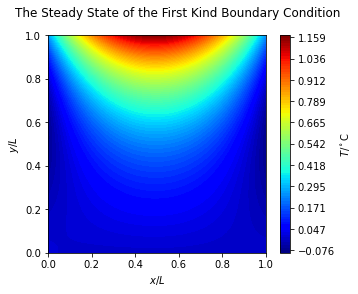

In [654]:
xt_plot = torch.linspace(0, 1, 100)
yt_plot = torch.linspace(0, 1, 100)
[xt_plot, yt_plot] = torch.meshgrid(xt_plot, yt_plot)
X = torch.cat((xt_plot.reshape(-1)[:, None], yt_plot.reshape(-1)[:, None]), axis=1).to(device)
T = NeuralTemp(X)
xt_plot = X[:, 0].reshape(100, 100).cpu().detach().numpy()
yt_plot = X[:, 1].reshape(100, 100).cpu().detach().numpy()
T = T.reshape(100, 100).cpu().detach().numpy()

from matplotlib import cm
fig = plt.figure(figsize=(5, 4))
fig.suptitle("The Steady State of the First Kind Boundary Condition")
ax = fig.add_subplot(111)
cs = ax.contourf(xt_plot, yt_plot, T, 100, cmap=cm.jet)
colorbar = fig.colorbar(cs)
colorbar.set_ticks(np.linspace(np.min(T), np.max(T), 11))
colorbar.set_label(r'$T/\mathrm{^\circ C}$')
"""
More information about colorbar can be found at the official documentation.
I've been bordered with this problem for a long time. It is very helpful!!!
https://matplotlib.org/3.5.0/api/colorbar_api.html#matplotlib.colorbar.Colorbar
"""

ax = plt.gca()
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
ax.set_aspect(1)

In [649]:
torch.jit.script(NeuralTemp).save("FixedValue.pt")
# model = torch.jit.load('model_scripted.pt')
# model.eval()

In [651]:
model = torch.jit.load('FixedValue.pt')
model.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=Sigmoid)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=Sigmoid)
  (4): RecursiveScriptModule(original_name=Linear)
  (5): RecursiveScriptModule(original_name=Sigmoid)
  (6): RecursiveScriptModule(original_name=Linear)
  (7): RecursiveScriptModule(original_name=Sigmoid)
  (8): RecursiveScriptModule(original_name=Linear)
)

In [655]:
model(X)

tensor([[0.0041],
        [0.0035],
        [0.0029],
        ...,
        [0.2144],
        [0.2307],
        [0.2476]], device='cuda:0', grad_fn=<MmBackward0>)